In [1]:
%pip install -U  langgraph

  Using cached PyYAML-6.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached jsonpointer-3.0.0-py2.py3-none-any.whl.metadata (2.3 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
  Using cached zstandard-0.23.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.0 kB)
  Using cached anyio-4.9.0-py3-none-any.whl.metadata (4.7 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached charset_normalizer-3.4.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (35 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
Using cached httpx-0.28.1-py3-none-any.whl (73 kB)
Using cached packaging-24.2-py3-none-any.whl (65 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [56]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Define basic types
class Feedback(TypedDict):
    id: str
    text: str
    rating: int


In [61]:
from typing import Annotated
from operator import add

class FeedbackState(TypedDict):
    feedbacks: Annotated[list[Feedback], add]

class AnalysisOutput(TypedDict):
    sentiment: str
    urgency: str
    recommendation: str

# Sentiment Analysis Subgraph
def analyze_rating(state: FeedbackState):
    total = 0
    for feedback in state['feedbacks']:
        total += feedback['rating']
    avg = total / len(state['feedbacks'])
    return {"avg_rating": avg, "feedbacks": state["feedbacks"]}

def get_sentiment(state):
    avg = state.get('avg_rating', 0)
    if avg >= 4:
        return {"sentiment": "Positive"}
    elif avg <= 2:
        return {"sentiment": "Negative"}
    return {"sentiment": "Neutral"}

# Build sentiment subgraph
sentiment_builder = StateGraph(FeedbackState)
sentiment_builder.add_node("analyze_rating", analyze_rating)
sentiment_builder.add_node("get_sentiment", get_sentiment)
sentiment_builder.add_edge(START, "analyze_rating")
sentiment_builder.add_edge("analyze_rating", "get_sentiment")
sentiment_builder.add_edge("get_sentiment", END)
sentiment_graph = sentiment_builder.compile()

In [62]:

# Urgency Analysis Subgraph
def count_low_ratings(state: FeedbackState):
    count = sum(1 for f in state['feedbacks'] if f['rating'] <= 2)
    return {"low_ratings": count, "feedbacks": state["feedbacks"]}

def determine_urgency(state):
    if state.get('low_ratings', 0) >= 2:
        return {"urgency": "High"}
    return {"urgency": "Low"}

# Build urgency subgraph
urgency_builder = StateGraph(FeedbackState)
urgency_builder.add_node("count_low_ratings", count_low_ratings)
urgency_builder.add_node("determine_urgency", determine_urgency)
urgency_builder.add_edge(START, "count_low_ratings")
urgency_builder.add_edge("count_low_ratings", "determine_urgency")
urgency_builder.add_edge("determine_urgency", END)
urgency_graph = urgency_builder.compile()


In [65]:

# Main Graph
class MainState(TypedDict):
    feedbacks: Annotated[list[Feedback], add]

def prepare_feedback(state: MainState):
    return {"feedbacks": state["feedbacks"]}

def combine_results(state: dict):
    sentiment = state.get("sentiment_subgraph", {}).get("sentiment", "Unknown")
    urgency = state.get("urgency_subgraph", {}).get("urgency", "Unknown")
    
    recommendation = "No action needed"
    if sentiment == "Negative" and urgency == "High":
        recommendation = "Immediate attention required"
    elif sentiment == "Negative" or urgency == "High":
        recommendation = "Follow up needed"
    
    return {
        "sentiment": sentiment,
        "urgency": urgency,
        "recommendation": recommendation
    }

# Build main graph
main_builder = StateGraph(MainState)
main_builder.add_node("prepare", prepare_feedback)
main_builder.add_node("sentiment_subgraph", sentiment_graph)
main_builder.add_node("urgency_subgraph", urgency_graph)
main_builder.add_node("combine", combine_results)

main_builder.add_edge(START, "prepare")
main_builder.add_edge("prepare", "sentiment_subgraph")
main_builder.add_edge("prepare", "urgency_subgraph")
main_builder.add_edge("sentiment_subgraph", "combine")
main_builder.add_edge("urgency_subgraph", "combine")
main_builder.add_edge("combine", END)

main_graph = main_builder.compile()

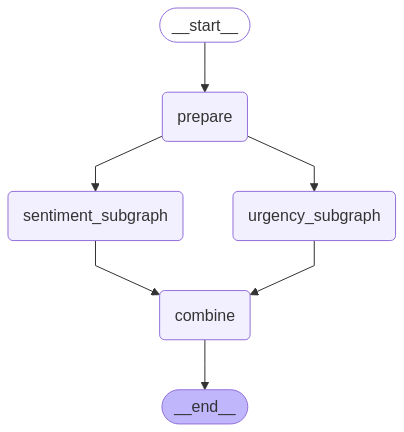


Analysis Result: {'feedbacks': [{'id': '1', 'text': 'Great service!', 'rating': 5}, {'id': '2', 'text': 'Poor experience', 'rating': 1}, {'id': '3', 'text': 'Terrible support', 'rating': 1}, {'id': '1', 'text': 'Great service!', 'rating': 5}, {'id': '2', 'text': 'Poor experience', 'rating': 1}, {'id': '3', 'text': 'Terrible support', 'rating': 1}, {'id': '1', 'text': 'Great service!', 'rating': 5}, {'id': '2', 'text': 'Poor experience', 'rating': 1}, {'id': '3', 'text': 'Terrible support', 'rating': 1}, {'id': '1', 'text': 'Great service!', 'rating': 5}, {'id': '2', 'text': 'Poor experience', 'rating': 1}, {'id': '3', 'text': 'Terrible support', 'rating': 1}, {'id': '1', 'text': 'Great service!', 'rating': 5}, {'id': '2', 'text': 'Poor experience', 'rating': 1}, {'id': '3', 'text': 'Terrible support', 'rating': 1}, {'id': '1', 'text': 'Great service!', 'rating': 5}, {'id': '2', 'text': 'Poor experience', 'rating': 1}, {'id': '3', 'text': 'Terrible support', 'rating': 1}, {'id': '1', '

In [67]:

# Test the graph
sample_input = {
    "feedbacks": [
        {"id": "1", "text": "Great service!", "rating": 5},
        {"id": "2", "text": "Poor experience", "rating": 1},
        {"id": "3", "text": "Terrible support", "rating": 1}
    ]
}

# Display graph visualization
display(Image(main_graph.get_graph().draw_mermaid_png()))

# Run the analysis
result = main_graph.invoke(sample_input)
print("\nAnalysis Result:", result)